In [19]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from sklearn.svm import SVR, OneClassSVM
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from scipy.stats import zscore, t

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import IsolationForest

from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.neighbors import LocalOutlierFactor


from sklearn.feature_selection import RFE,RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectFromModel


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [20]:
def get_soc(kernel,sp,p):
    if kernel=='rbf':
        return sp*(3*p+1)
    if kernel == 'linear':
        return sp*(2*p-1)
    return sp*(2*p+2)

def soc_metric(model,*args,**kwargs):
  X,y=args
  return -get_soc(model.kernel,len(model.support_vectors_),X.shape[1])

In [21]:
uploaded = 'http://archive.ics.uci.edu/ml/machine-learning-databases/servo/servo.data'
column_names = ['motor','screw','pgain','vgain','class']
df = pd.read_csv(uploaded,names=column_names)

In [22]:
df[['motor','screw']] = OrdinalEncoder().fit_transform(df[['motor','screw']])
X=df[column_names[:-1]]
y=df[column_names[-1]]
print(X.shape)
pd.DataFrame(data=[df.skew(),df.kurtosis()],index=['skewness','kurtosis'])

(167, 4)


,motor,screw,pgain,vgain,class
skewness,0.175841,0.170644,0.549742,0.522405,1.790989
kurtosis,-1.219915,-1.314239,-0.774954,-0.968469,2.072995


In [23]:
outliers = LocalOutlierFactor(n_neighbors=150).fit_predict(X)
target_out = LocalOutlierFactor(n_neighbors=150).fit_predict(y.values.reshape(-1, 1))
outliers = outliers == 1
target_out = target_out == 1
for i,t in enumerate(target_out):
  outliers[i]=outliers[i] and t

X,y=X[outliers],y[outliers]
X.shape

(165, 4)

In [24]:
X = StandardScaler().fit_transform(X)

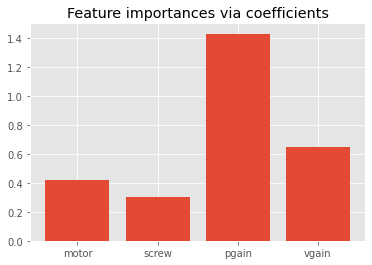

In [25]:
model=LinearRegression()
model.fit(X,y)
feature_importances = np.abs(model.coef_)
feature_names = df.columns.to_numpy()
plt.bar(height=feature_importances, x=feature_names[:-1])
plt.title("Feature importances via coefficients")
plt.show()

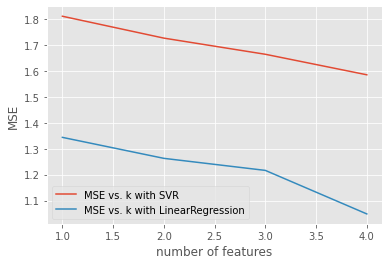

In [26]:
cv=10
grid = dict()
grid['sel__k'] = [i for i in range(1,5)]

models=[(SVR(kernel='linear'),'SVR'),(LinearRegression(),'LinearRegression')]

for model,name in models:
  fs = SelectKBest(score_func=mutual_info_regression)
  pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])

  gcv = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)

  results = gcv.fit(X, y)
  means = results.cv_results_['mean_test_score']
  params = results.cv_results_['params']
  params =[d['sel__k'] for d in params]
  for i in range(len(means)):
      means[i]=-means[i]

  plt.plot(params,means,label='MSE vs. k with '+name)
  plt.legend()
  plt.xlabel('number of features')
  plt.ylabel('MSE')
plt.show()

In [27]:
k=1
X=SelectKBest(score_func=mutual_info_regression,k=k).fit_transform(X,y)

In [28]:
acc_metric='neg_mean_squared_error'
model_selected=None
minRMSE=np.inf
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])

Best Hyperparameters::
{'C': 18.42105263157895, 'kernel': 'linear'}
Best Hyperparameters::
{'C': 39.473684210526315, 'kernel': 'linear'}
SOC:  137
MSE:  1.8105408960455462 STD:  1.0102591677873731


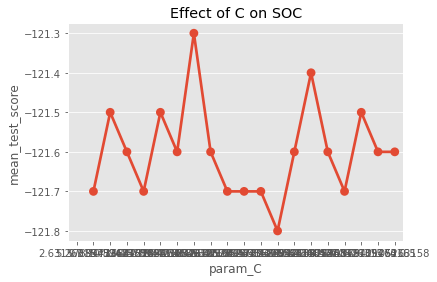

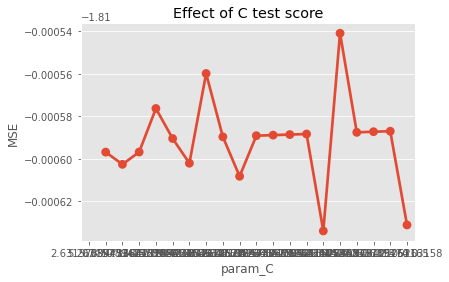

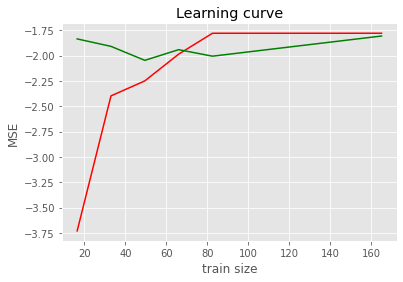

In [29]:
params = {'C':np.linspace(0,50,20),
          'kernel':['linear']}

gcv = GridSearchCV(SVR(),params,cv=cv,scoring=soc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots()
sns.pointplot(data=results[['mean_test_score',
                           'param_C']],
             y='mean_test_score',x='param_C')
ax.set(title="Effect of C on SOC")

gcv = GridSearchCV(SVR(),params,cv=cv,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots()
sns.pointplot(data=results[['mean_test_score',
                           'param_C']],
             y='mean_test_score',x='param_C')
ax.set(title="Effect of C test score")
ax.set(ylabel='MSE')
svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k-1))
_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)

mse=cross_val_score(svr,X,y,cv=10,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-')
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

Best Hyperparameters::
{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Best Hyperparameters::
{'C': 46.41588833612773, 'gamma': 0.046415888336127774, 'kernel': 'rbf'}
# SV 129
SOC:  516
MSE:  0.9448865682015818 STD:  0.46385400505809005


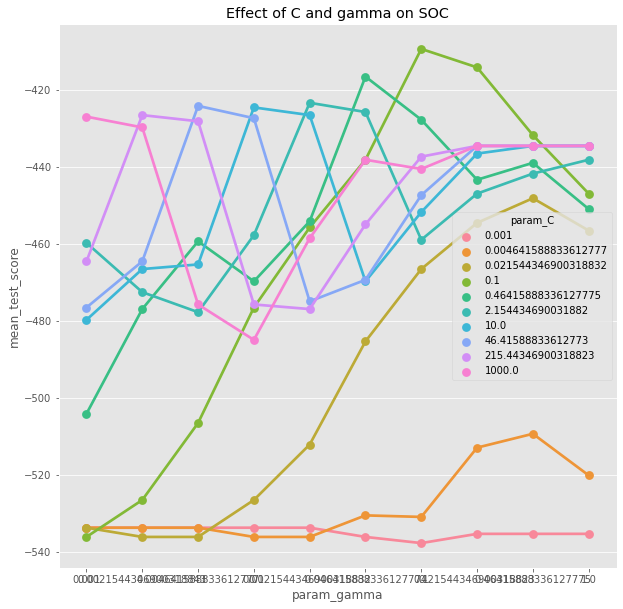

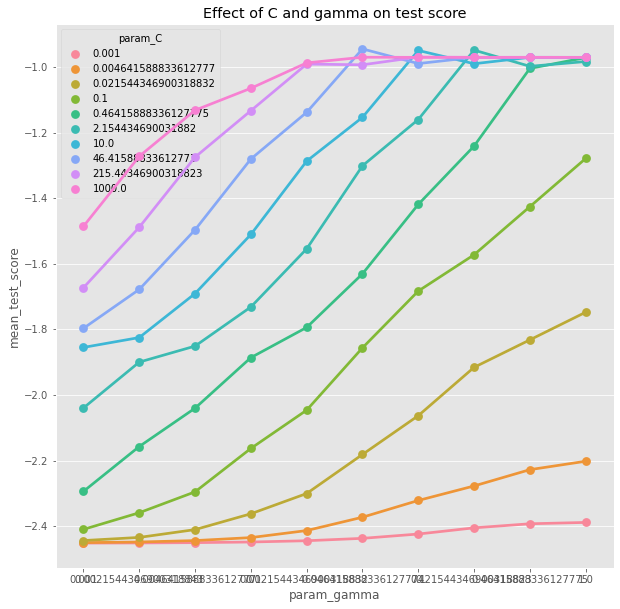

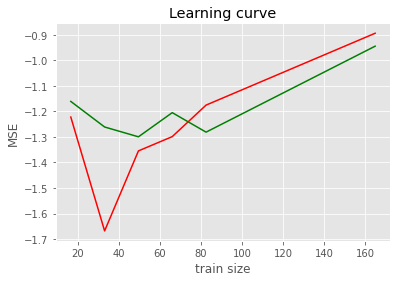

In [30]:
params = {'C':np.logspace(-3,3,10),
          'gamma':np.logspace(-3,0,10),
          'kernel':['rbf',]}

gcv = GridSearchCV(SVR(),params,cv=cv,scoring=soc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(10,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on SOC")


gcv = GridSearchCV(SVR(),params,cv=cv,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(10,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")
svr=gcv.best_estimator_
print("# SV",len(svr.support_vectors_))
print("SOC: ",len(svr.support_vectors_)*(3*k+1))
_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)

mse=cross_val_score(svr,X,y,cv=10,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-')
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()


Best Hyperparameters::
{'C': 11.111111111111107, 'gamma': 0.00035938136638046257, 'kernel': 'sigmoid'}
Best Hyperparameters::
{'C': 23.33333333333333, 'gamma': 0.016681005372000592, 'kernel': 'sigmoid'}
SOC:  544
MSE:  1.8117098581336317 STD:  1.0107431639703066


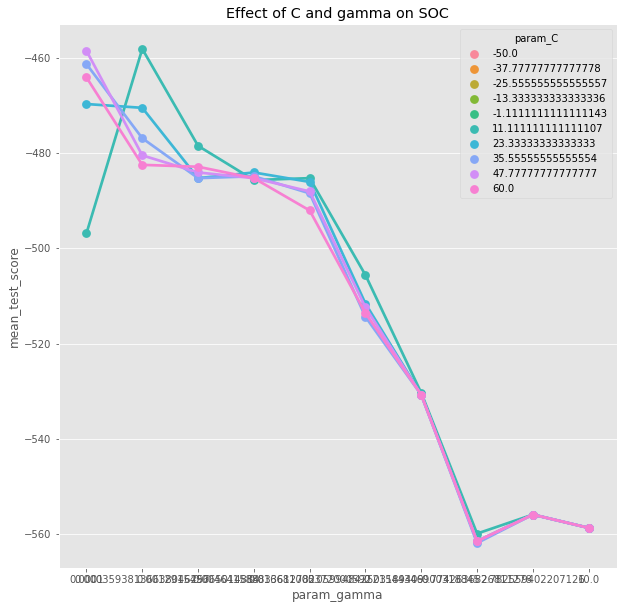

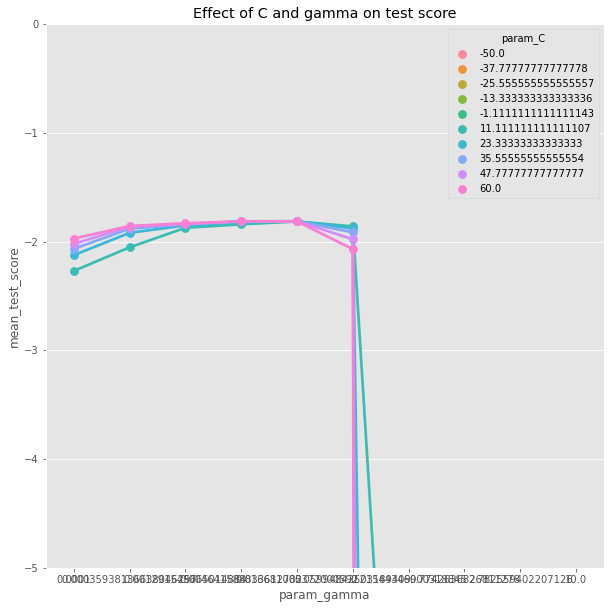

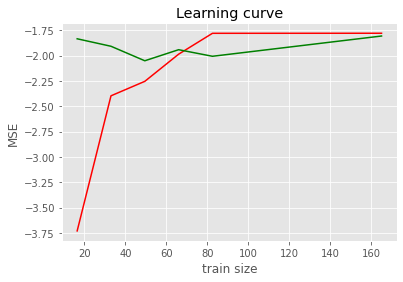

In [34]:
params = {'C':np.linspace(-50,60,10),
          'gamma':np.logspace(-4,1,10),
          'kernel':['sigmoid',]}

gcv = GridSearchCV(SVR(),params,cv=cv,scoring=soc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(10,10))
# ax.set_ylim([-5,0])
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on SOC")


gcv = GridSearchCV(SVR(),params,cv=cv,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(10,10))
ax.set_ylim([-5,0])
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")
svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k+2))
_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)

mse=cross_val_score(svr,X,y,cv=10,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-')
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

Best Hyperparameters::
{'C': 1, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
Best Hyperparameters::
{'C': 2, 'degree': 3, 'gamma': 2, 'kernel': 'poly'}
SOC:  540
MSE:  2.0754900238226806 STD:  1.1512110251595118


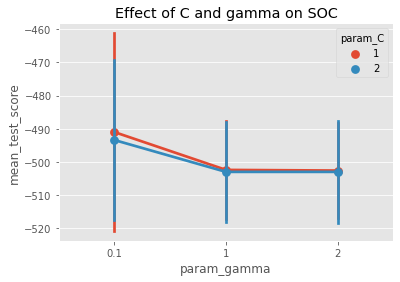

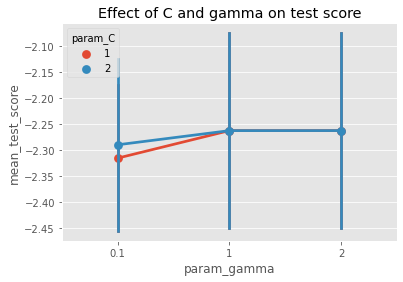

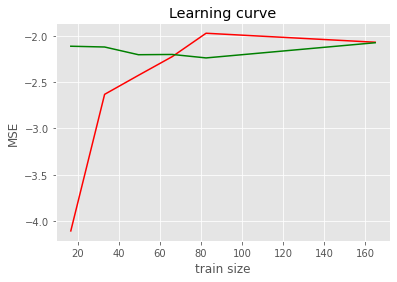

In [32]:
params = {'C':[1,2],
          'gamma':[0.1,1,2],
          'degree':[2,3],
          'kernel':['poly'],
         }

gcv = GridSearchCV(SVR(),params,cv=cv,scoring=soc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots()
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on SOC")


gcv = GridSearchCV(SVR(),params,cv=cv,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots()
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")
svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k+2))
_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)

mse=cross_val_score(svr,X,y,cv=10,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-')
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

In [ ]:
def get_soc(kernel,sp,p):
    if kernel=='rbf':
        return sp*(3*p+1)
    if kernel == 'linear':
        return sp*(2*p-1)
    return sp*(2*p+2)

In [ ]:
soc=get_soc(model_selected.kernel,len(model_selected.support_vectors_),k)
print('Best Model:')
print(model_selected, 'kernel: ',model_selected.kernel)
print('SOC ',soc)
print('MSE ',minRMSE)

Best Model:
SVR(C=215.44346900318823, gamma=0.1) kernel:  rbf
SOC  1261
MSE  0.13020791720080577


In [ ]:
import pickle
!git clone https://github.com/zhumakhan/IML.git
filename='./servo+svr.model'

with open(filename, 'wb') as file:
    pickle.dump(model_selected,file)

!mv ./servo+svr.model ./IML/servo+svr.model
!cd IML && git add . && git commit -m'svr model update' && git push --force
!rm -rf ./IML
# some time later...
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

fatal: destination path 'IML' already exists and is not an empty directory.
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
